<a href="https://colab.research.google.com/github/chandanakommineni/movie-recommendation-system-using-NLP/blob/main/movie_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

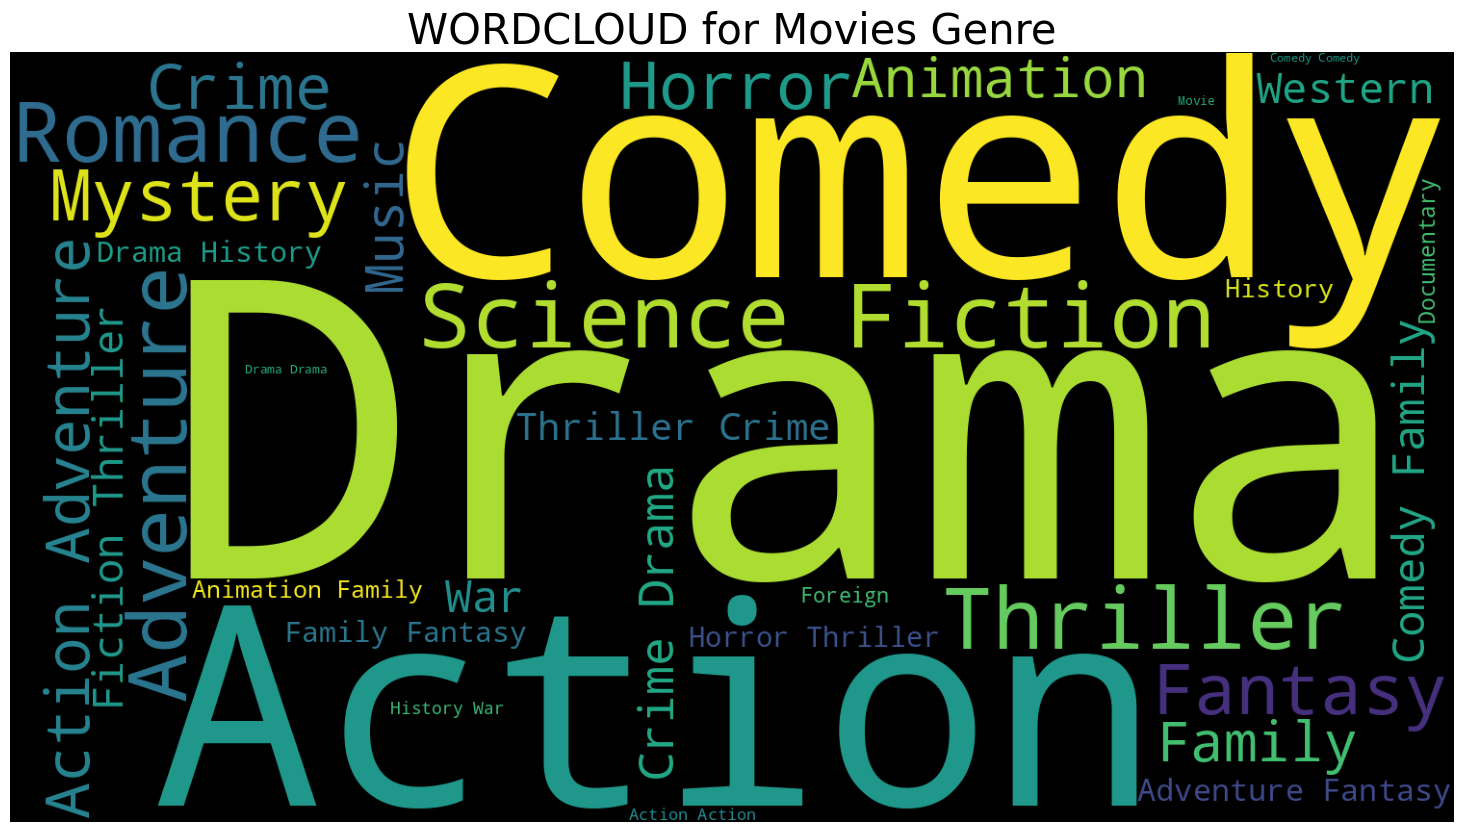

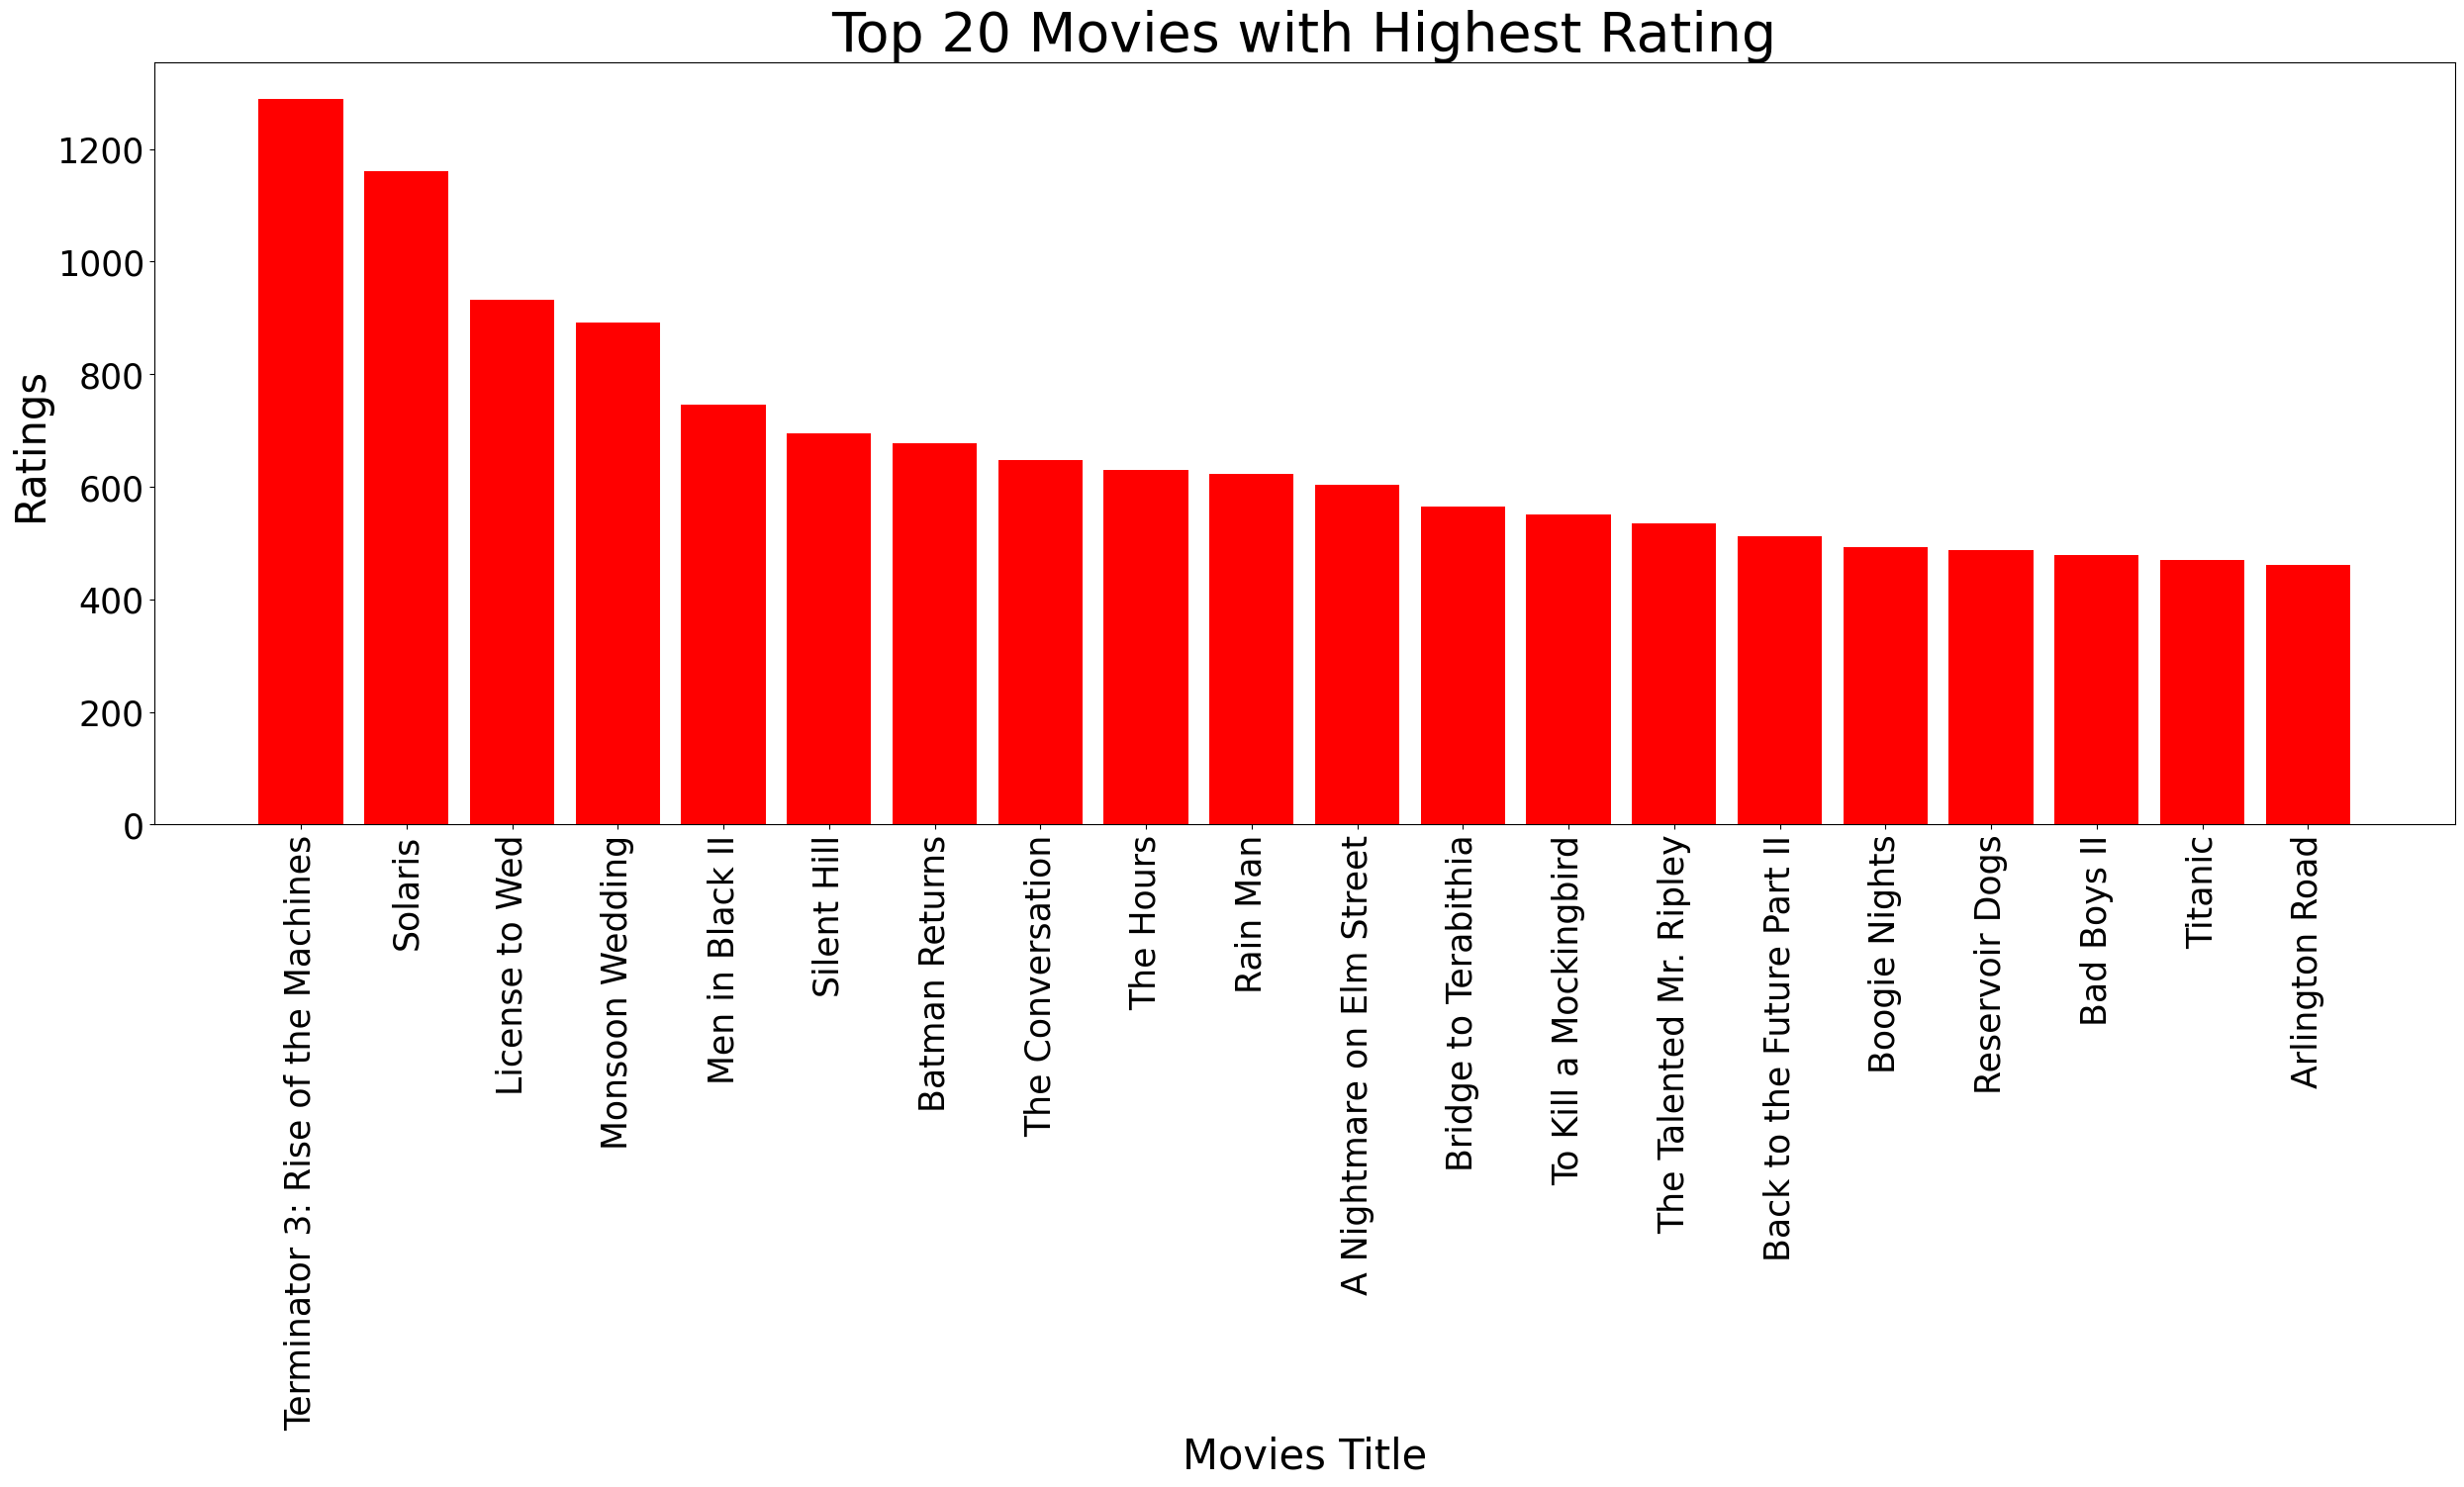

Sample movie titles in dataset: ['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice']
Recommended movies for 'Toy Story': ['Happy Feet Two', 'Monsters, Inc.', "Surf's Up", 'Toy Story 2', 'Cloudy with a Chance of Meatballs', 'Over the Hedge', 'Hotel Transylvania 2', 'Looney Tunes: Back in Action', 'Cloudy with a Chance of Meatballs 2', 'Despicable Me 2', 'The Simpsons Movie', 'Hop', 'Chicken Little', 'Garfield: A Tail of Two Kitties', 'Free Birds', 'Barnyard', 'Garfield', 'Chicken Run', 'Frankenweenie', 'Toy Story']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import difflib

# Load datasets
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Ensure 'movieId' is present in both DataFrames before merging
if 'movieId' in ratings.columns and 'id' in movies.columns:
    movies.rename(columns={'id': 'movieId'}, inplace=True)
    df = pd.merge(ratings, movies, how='left', on='movieId')
else:
    print("Error: 'movieId' column not found in one of the DataFrames.")
    df = pd.DataFrame()

# Proceed only if the merge was successful
if not df.empty:
    # Extract unique genres
    genres = set()
    for genre in movies['genres'].dropna():
        genres.update(genre.split('|'))

    # Generate WordCloud for genres
    wordcloud_genre = WordCloud(width=1500, height=800, background_color='black', min_font_size=2, min_word_length=3).generate(" ".join(genres))
    plt.figure(figsize=(30, 10))
    plt.axis('off')
    plt.title('WORDCLOUD for Movies Genre', fontsize=30)
    plt.imshow(wordcloud_genre)
    plt.show()

    # Get top 20 high-rated movies
    df1 = df.groupby('title')[['rating']].sum()
    high_rated = df1.nlargest(20, 'rating')

    plt.figure(figsize=(30, 10))
    plt.title('Top 20 Movies with Highest Rating', fontsize=40)
    plt.bar(high_rated.index, high_rated['rating'], color='red')
    plt.xticks(rotation=90, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel('Movies Title', fontsize=30)
    plt.ylabel('Ratings', fontsize=30)
    plt.show()

    # Create TF-IDF matrix
    cv = TfidfVectorizer()
    tfidf_matrix = cv.fit_transform(movies['genres'].fillna(''))

    # Compute Cosine Similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Normalize movie titles for better matching
    movies['title_lower'] = movies['title'].str.lower().str.strip()
    indices = pd.Series(movies.index, index=movies['title_lower']).drop_duplicates()

    def recommendations(title):
        title = title.strip().lower()

        if title not in indices:
            similar_titles = difflib.get_close_matches(title, movies['title_lower'].tolist(), n=5)
            return f"Movie title not found. Did you mean: {similar_titles}?" if similar_titles else "Movie title not found."

        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:21]
        movie_indices = [i[0] for i in sim_scores]
        return movies['title'].iloc[movie_indices].tolist()

    # Debug: Check available titles
    print("Sample movie titles in dataset:", movies['title'].head(10).tolist())

    # Example recommendation
    print("Recommended movies for 'Toy Story':", recommendations('Toy Story'))
